# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 992us/sample - loss: 293.4675 - y1_output_loss: 138.0127 - y2_output_loss: 152.6630 - y1_output_root_mean_squared_error: 11.8042 - y2_output_root_mean_squared_error: 12.4148 - val_loss: 43.8737 - val_y1_output_loss: 18.6641 - val_y2_output_loss: 28.9031 - val_y1_output_root_mean_squared_error: 4.1988 - val_y2_output_root_mean_squared_error: 5.1229
Epoch 2/500
614/614 [==============================] - 0s 153us/sample - loss: 31.6520 - y1_output_loss: 12.6246 - y2_output_loss: 18.8027 - y1_output_root_mean_squared_error: 3.5672 - y2_output_root_mean_squared_error: 4.3505 - val_loss: 24.2238 - val_y1_output_loss: 10.9565 - val_y2_output_loss: 15.0586 - val_y1_output_root_mean_squared_error: 3.2579 - val_y2_output_root_mean_squared_error: 3.6892
Epoch 3/500
614/614 [==============================] - 0s 143us/sample - loss: 26.6678 - y1_output_loss: 10.3208 - y2_output_loss: 16.2875 - y1

614/614 [==============================] - 0s 139us/sample - loss: 9.8635 - y1_output_loss: 3.2947 - y2_output_loss: 6.4897 - y1_output_root_mean_squared_error: 1.8230 - y2_output_root_mean_squared_error: 2.5574 - val_loss: 7.7095 - val_y1_output_loss: 2.9030 - val_y2_output_loss: 4.8785 - val_y1_output_root_mean_squared_error: 1.7228 - val_y2_output_root_mean_squared_error: 2.1775
Epoch 42/500
614/614 [==============================] - 0s 136us/sample - loss: 7.7637 - y1_output_loss: 2.7784 - y2_output_loss: 5.0285 - y1_output_root_mean_squared_error: 1.6613 - y2_output_root_mean_squared_error: 2.2369 - val_loss: 24.7789 - val_y1_output_loss: 7.1837 - val_y2_output_loss: 18.3428 - val_y1_output_root_mean_squared_error: 2.6776 - val_y2_output_root_mean_squared_error: 4.1964
Epoch 43/500
614/614 [==============================] - 0s 144us/sample - loss: 11.7257 - y1_output_loss: 3.7601 - y2_output_loss: 7.9693 - y1_output_root_mean_squared_error: 1.9372 - y2_output_root_mean_squared_err

Epoch 62/500
614/614 [==============================] - 0s 139us/sample - loss: 5.3050 - y1_output_loss: 1.4525 - y2_output_loss: 3.8142 - y1_output_root_mean_squared_error: 1.2091 - y2_output_root_mean_squared_error: 1.9603 - val_loss: 5.3156 - val_y1_output_loss: 1.6855 - val_y2_output_loss: 3.5841 - val_y1_output_root_mean_squared_error: 1.3126 - val_y2_output_root_mean_squared_error: 1.8954
Epoch 63/500
614/614 [==============================] - 0s 138us/sample - loss: 5.0284 - y1_output_loss: 1.3677 - y2_output_loss: 3.6836 - y1_output_root_mean_squared_error: 1.1718 - y2_output_root_mean_squared_error: 1.9119 - val_loss: 8.5772 - val_y1_output_loss: 2.1823 - val_y2_output_loss: 6.3719 - val_y1_output_root_mean_squared_error: 1.4890 - val_y2_output_root_mean_squared_error: 2.5219
Epoch 64/500
614/614 [==============================] - 0s 136us/sample - loss: 9.1495 - y1_output_loss: 2.6774 - y2_output_loss: 6.4224 - y1_output_root_mean_squared_error: 1.6347 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 138us/sample - loss: 3.1246 - y1_output_loss: 0.6910 - y2_output_loss: 2.4220 - y1_output_root_mean_squared_error: 0.8343 - y2_output_root_mean_squared_error: 1.5584 - val_loss: 4.3241 - val_y1_output_loss: 0.8714 - val_y2_output_loss: 3.5443 - val_y1_output_root_mean_squared_error: 0.9405 - val_y2_output_root_mean_squared_error: 1.8546
Epoch 84/500
614/614 [==============================] - 0s 144us/sample - loss: 3.3669 - y1_output_loss: 0.7641 - y2_output_loss: 2.5949 - y1_output_root_mean_squared_error: 0.8777 - y2_output_root_mean_squared_error: 1.6114 - val_loss: 6.8953 - val_y1_output_loss: 0.9275 - val_y2_output_loss: 5.9359 - val_y1_output_root_mean_squared_error: 0.9684 - val_y2_output_root_mean_squared_error: 2.4408
Epoch 85/500
614/614 [==============================] - 0s 139us/sample - loss: 3.4358 - y1_output_loss: 0.9016 - y2_output_loss: 2.5378 - y1_output_root_mean_squared_error: 0.9531 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 141us/sample - loss: 2.4289 - y1_output_loss: 0.5914 - y2_output_loss: 1.8330 - y1_output_root_mean_squared_error: 0.7703 - y2_output_root_mean_squared_error: 1.3548 - val_loss: 2.7665 - val_y1_output_loss: 0.7242 - val_y2_output_loss: 2.1882 - val_y1_output_root_mean_squared_error: 0.8627 - val_y2_output_root_mean_squared_error: 1.4220
Epoch 105/500
614/614 [==============================] - 0s 132us/sample - loss: 2.1406 - y1_output_loss: 0.4442 - y2_output_loss: 1.6793 - y1_output_root_mean_squared_error: 0.6689 - y2_output_root_mean_squared_error: 1.3012 - val_loss: 2.5540 - val_y1_output_loss: 0.5753 - val_y2_output_loss: 2.1430 - val_y1_output_root_mean_squared_error: 0.7690 - val_y2_output_root_mean_squared_error: 1.4010
Epoch 106/500
614/614 [==============================] - 0s 136us/sample - loss: 2.6572 - y1_output_loss: 0.6070 - y2_output_loss: 2.0378 - y1_output_root_mean_squared_error: 0.7791 - y2_output_root_mea

Epoch 145/500
614/614 [==============================] - 0s 151us/sample - loss: 1.7998 - y1_output_loss: 0.3317 - y2_output_loss: 1.4829 - y1_output_root_mean_squared_error: 0.5761 - y2_output_root_mean_squared_error: 1.2116 - val_loss: 6.0962 - val_y1_output_loss: 1.2165 - val_y2_output_loss: 5.0099 - val_y1_output_root_mean_squared_error: 1.0906 - val_y2_output_root_mean_squared_error: 2.2151
Epoch 146/500
614/614 [==============================] - 0s 150us/sample - loss: 1.7787 - y1_output_loss: 0.4108 - y2_output_loss: 1.3613 - y1_output_root_mean_squared_error: 0.6431 - y2_output_root_mean_squared_error: 1.1684 - val_loss: 3.1044 - val_y1_output_loss: 0.7081 - val_y2_output_loss: 2.6404 - val_y1_output_root_mean_squared_error: 0.8407 - val_y2_output_root_mean_squared_error: 1.5484
Epoch 147/500
614/614 [==============================] - 0s 146us/sample - loss: 1.6407 - y1_output_loss: 0.3311 - y2_output_loss: 1.3082 - y1_output_root_mean_squared_error: 0.5761 - y2_output_root_mea

Epoch 186/500
614/614 [==============================] - 0s 140us/sample - loss: 1.9159 - y1_output_loss: 0.3455 - y2_output_loss: 1.5671 - y1_output_root_mean_squared_error: 0.5879 - y2_output_root_mean_squared_error: 1.2531 - val_loss: 3.1290 - val_y1_output_loss: 0.4082 - val_y2_output_loss: 2.7716 - val_y1_output_root_mean_squared_error: 0.6391 - val_y2_output_root_mean_squared_error: 1.6494
Epoch 187/500
614/614 [==============================] - 0s 127us/sample - loss: 1.1295 - y1_output_loss: 0.2652 - y2_output_loss: 0.8702 - y1_output_root_mean_squared_error: 0.5110 - y2_output_root_mean_squared_error: 0.9319 - val_loss: 4.1853 - val_y1_output_loss: 1.6294 - val_y2_output_loss: 2.6702 - val_y1_output_root_mean_squared_error: 1.2897 - val_y2_output_root_mean_squared_error: 1.5881
Epoch 188/500
614/614 [==============================] - 0s 150us/sample - loss: 1.3126 - y1_output_loss: 0.3213 - y2_output_loss: 0.9833 - y1_output_root_mean_squared_error: 0.5685 - y2_output_root_mea

Epoch 227/500
614/614 [==============================] - 0s 138us/sample - loss: 1.2864 - y1_output_loss: 0.2556 - y2_output_loss: 1.0228 - y1_output_root_mean_squared_error: 0.5070 - y2_output_root_mean_squared_error: 1.0146 - val_loss: 1.5693 - val_y1_output_loss: 0.2900 - val_y2_output_loss: 1.3455 - val_y1_output_root_mean_squared_error: 0.5428 - val_y2_output_root_mean_squared_error: 1.1290
Epoch 228/500
614/614 [==============================] - 0s 126us/sample - loss: 1.4036 - y1_output_loss: 0.3342 - y2_output_loss: 1.0823 - y1_output_root_mean_squared_error: 0.5784 - y2_output_root_mean_squared_error: 1.0339 - val_loss: 4.3505 - val_y1_output_loss: 0.4206 - val_y2_output_loss: 4.2604 - val_y1_output_root_mean_squared_error: 0.6562 - val_y2_output_root_mean_squared_error: 1.9799
Epoch 229/500
614/614 [==============================] - 0s 140us/sample - loss: 1.1348 - y1_output_loss: 0.2448 - y2_output_loss: 0.9228 - y1_output_root_mean_squared_error: 0.4914 - y2_output_root_mea

Epoch 268/500
614/614 [==============================] - 0s 132us/sample - loss: 0.7259 - y1_output_loss: 0.1852 - y2_output_loss: 0.5368 - y1_output_root_mean_squared_error: 0.4311 - y2_output_root_mean_squared_error: 0.7349 - val_loss: 1.3394 - val_y1_output_loss: 0.2666 - val_y2_output_loss: 1.1493 - val_y1_output_root_mean_squared_error: 0.5223 - val_y2_output_root_mean_squared_error: 1.0327
Epoch 269/500
614/614 [==============================] - 0s 143us/sample - loss: 0.8718 - y1_output_loss: 0.1935 - y2_output_loss: 0.6801 - y1_output_root_mean_squared_error: 0.4413 - y2_output_root_mean_squared_error: 0.8228 - val_loss: 4.1200 - val_y1_output_loss: 0.4422 - val_y2_output_loss: 3.7140 - val_y1_output_root_mean_squared_error: 0.6610 - val_y2_output_root_mean_squared_error: 1.9191
Epoch 270/500
614/614 [==============================] - 0s 150us/sample - loss: 0.9365 - y1_output_loss: 0.2136 - y2_output_loss: 0.7388 - y1_output_root_mean_squared_error: 0.4616 - y2_output_root_mea

Epoch 309/500
614/614 [==============================] - 0s 154us/sample - loss: 1.0842 - y1_output_loss: 0.2232 - y2_output_loss: 0.8595 - y1_output_root_mean_squared_error: 0.4746 - y2_output_root_mean_squared_error: 0.9268 - val_loss: 1.5317 - val_y1_output_loss: 0.2343 - val_y2_output_loss: 1.3214 - val_y1_output_root_mean_squared_error: 0.4896 - val_y2_output_root_mean_squared_error: 1.1367
Epoch 310/500
614/614 [==============================] - 0s 148us/sample - loss: 0.7794 - y1_output_loss: 0.1584 - y2_output_loss: 0.6191 - y1_output_root_mean_squared_error: 0.3993 - y2_output_root_mean_squared_error: 0.7874 - val_loss: 1.3939 - val_y1_output_loss: 0.2690 - val_y2_output_loss: 1.2024 - val_y1_output_root_mean_squared_error: 0.5207 - val_y2_output_root_mean_squared_error: 1.0596
Epoch 311/500
614/614 [==============================] - 0s 144us/sample - loss: 1.1803 - y1_output_loss: 0.2463 - y2_output_loss: 0.9276 - y1_output_root_mean_squared_error: 0.4972 - y2_output_root_mea

Epoch 350/500
614/614 [==============================] - 0s 147us/sample - loss: 0.7640 - y1_output_loss: 0.1722 - y2_output_loss: 0.5888 - y1_output_root_mean_squared_error: 0.4147 - y2_output_root_mean_squared_error: 0.7695 - val_loss: 1.2719 - val_y1_output_loss: 0.2574 - val_y2_output_loss: 1.0095 - val_y1_output_root_mean_squared_error: 0.5144 - val_y2_output_root_mean_squared_error: 1.0036
Epoch 351/500
614/614 [==============================] - 0s 154us/sample - loss: 0.6390 - y1_output_loss: 0.1773 - y2_output_loss: 0.4586 - y1_output_root_mean_squared_error: 0.4228 - y2_output_root_mean_squared_error: 0.6784 - val_loss: 0.9742 - val_y1_output_loss: 0.2209 - val_y2_output_loss: 0.7681 - val_y1_output_root_mean_squared_error: 0.4743 - val_y2_output_root_mean_squared_error: 0.8656
Epoch 352/500
614/614 [==============================] - 0s 127us/sample - loss: 0.8330 - y1_output_loss: 0.1896 - y2_output_loss: 0.6385 - y1_output_root_mean_squared_error: 0.4372 - y2_output_root_mea

Epoch 391/500
614/614 [==============================] - 0s 141us/sample - loss: 0.5075 - y1_output_loss: 0.1611 - y2_output_loss: 0.3435 - y1_output_root_mean_squared_error: 0.4015 - y2_output_root_mean_squared_error: 0.5885 - val_loss: 0.9069 - val_y1_output_loss: 0.2075 - val_y2_output_loss: 0.6930 - val_y1_output_root_mean_squared_error: 0.4618 - val_y2_output_root_mean_squared_error: 0.8328
Epoch 392/500
614/614 [==============================] - 0s 153us/sample - loss: 0.5078 - y1_output_loss: 0.1377 - y2_output_loss: 0.3657 - y1_output_root_mean_squared_error: 0.3725 - y2_output_root_mean_squared_error: 0.6075 - val_loss: 1.0231 - val_y1_output_loss: 0.2300 - val_y2_output_loss: 0.7807 - val_y1_output_root_mean_squared_error: 0.4850 - val_y2_output_root_mean_squared_error: 0.8876
Epoch 393/500
614/614 [==============================] - 0s 148us/sample - loss: 0.5387 - y1_output_loss: 0.1674 - y2_output_loss: 0.3761 - y1_output_root_mean_squared_error: 0.4075 - y2_output_root_mea

Epoch 432/500
614/614 [==============================] - 0s 136us/sample - loss: 0.4274 - y1_output_loss: 0.1319 - y2_output_loss: 0.2925 - y1_output_root_mean_squared_error: 0.3642 - y2_output_root_mean_squared_error: 0.5429 - val_loss: 0.8693 - val_y1_output_loss: 0.2287 - val_y2_output_loss: 0.6324 - val_y1_output_root_mean_squared_error: 0.4818 - val_y2_output_root_mean_squared_error: 0.7982
Epoch 433/500
614/614 [==============================] - 0s 134us/sample - loss: 0.4065 - y1_output_loss: 0.1216 - y2_output_loss: 0.2824 - y1_output_root_mean_squared_error: 0.3493 - y2_output_root_mean_squared_error: 0.5334 - val_loss: 0.8981 - val_y1_output_loss: 0.2295 - val_y2_output_loss: 0.6570 - val_y1_output_root_mean_squared_error: 0.4847 - val_y2_output_root_mean_squared_error: 0.8144
Epoch 434/500
614/614 [==============================] - 0s 140us/sample - loss: 0.4778 - y1_output_loss: 0.1213 - y2_output_loss: 0.3523 - y1_output_root_mean_squared_error: 0.3495 - y2_output_root_mea

Epoch 473/500
614/614 [==============================] - 0s 145us/sample - loss: 0.4104 - y1_output_loss: 0.1165 - y2_output_loss: 0.3131 - y1_output_root_mean_squared_error: 0.3405 - y2_output_root_mean_squared_error: 0.5427 - val_loss: 4.4761 - val_y1_output_loss: 0.6934 - val_y2_output_loss: 3.8138 - val_y1_output_root_mean_squared_error: 0.8297 - val_y2_output_root_mean_squared_error: 1.9462
Epoch 474/500
614/614 [==============================] - 0s 149us/sample - loss: 0.4493 - y1_output_loss: 0.1535 - y2_output_loss: 0.2928 - y1_output_root_mean_squared_error: 0.3928 - y2_output_root_mean_squared_error: 0.5431 - val_loss: 1.1006 - val_y1_output_loss: 0.2495 - val_y2_output_loss: 0.8314 - val_y1_output_root_mean_squared_error: 0.5048 - val_y2_output_root_mean_squared_error: 0.9197
Epoch 475/500
614/614 [==============================] - 0s 140us/sample - loss: 0.4073 - y1_output_loss: 0.1262 - y2_output_loss: 0.2882 - y1_output_root_mean_squared_error: 0.3559 - y2_output_root_mea

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 456us/sample - loss: 0.8183 - y1_output_loss: 0.2138 - y2_output_loss: 0.6025 - y1_output_root_mean_squared_error: 0.4618 - y2_output_root_mean_squared_error: 0.7778
Loss = 0.8182815739086696, Y1_loss = 0.21382644772529602, Y1_mse = 0.461847722530365, Y2_loss = 0.6025410294532776, Y2_mse = 0.7778034806251526


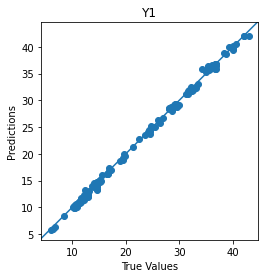

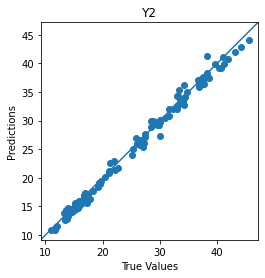

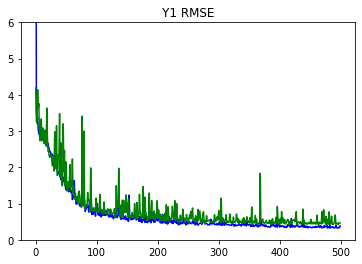

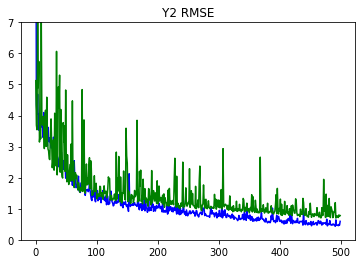

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)